In [ ]:
!pip install shortuuid

In [65]:
import copy
import csv
import cv2
import glob
import os
import re
import shutil
import time
from collections import Counter
from datetime import timedelta
import shortuuid

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(precision=4)

# Get reproducible results
random_state = 46
np.random.seed(random_state)
tf.random.set_seed(random_state)


def ann_file(data_dir):
    return os.path.join(data_dir, "TrainAnnotations.csv")


TRAIN_DATA_DIR = "data/TrainData-C1"
TRAIN_DATA_ANN_FILE = ann_file(TRAIN_DATA_DIR)

TRAIN_SPLIT_DATA_DIR           = "data-c1/train/split"
TRAIN_SPLIT_ANN_FILE           = ann_file(TRAIN_SPLIT_DATA_DIR)
TRAIN_SPLIT_AUGMENTED_DATA_DIR = "data-c1/train/augmented"
TRAIN_SPLIT_AUGMENTED_ANN_FILE = ann_file(TRAIN_SPLIT_AUGMENTED_DATA_DIR)
TRAIN_SPLIT_PATCHES_DATA_DIR   = "data-c1/train/patches"
TRAIN_SPLIT_PATCHES_ANN_FILE   = ann_file(TRAIN_SPLIT_PATCHES_DATA_DIR)

TRAIN_ALL_AUGMENTED_DATA_DIR   = "data-c1/train-all/augmented"
TRAIN_ALL_AUGMENTED_ANN_FILE   = ann_file(TRAIN_ALL_AUGMENTED_DATA_DIR)
TRAIN_ALL_PATCHES_DATA_DIR     = "data-c1/train-all/patches"
TRAIN_ALL_PATCHES_ANN_FILE     = ann_file(TRAIN_ALL_PATCHES_DATA_DIR)

VAL_SPLIT_DATA_DIR         = "data-c1/val/split"
VAL_SPLIT_ANN_FILE         = ann_file(VAL_SPLIT_DATA_DIR)
VAL_SPLIT_PATCHES_DATA_DIR = "data-c1/val/patches"
VAL_SPLIT_PATCHES_ANN_FILE = ann_file(VAL_SPLIT_PATCHES_DATA_DIR)

TEST_DATA_DIR         = "data/TestData/"

TEST_PATCHES_DATA_DIR = "data/test/"
#TEST_PATCHES_DATA_DIR = "data/test/patches"


## GPU configuration
If you have a GPU, enable experimental memory growth.

In [48]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Split data
Generate random, stratified 80/20 split for training and validation sets

In [49]:
if (os.path.exists(TRAIN_SPLIT_DATA_DIR) or os.path.exists(VAL_SPLIT_DATA_DIR)):
    print("Data directories for splits already exist. Skipping")
else:
    # Generate 80/20 split

    print("Reading {} annotations...".format(TRAIN_DATA_ANN_FILE))
    ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})

    print("Splitting data into training and validation sets...")
    train_df, val_df = train_test_split(ann_df,
                                        train_size=0.80,
                                        random_state=138,
                                        shuffle=True,
                                        stratify=ann_df[['annotation']].to_numpy(dtype=np.int32).flatten())

    os.makedirs(TRAIN_SPLIT_DATA_DIR)
    os.makedirs(VAL_SPLIT_DATA_DIR)
    
    print("Copying files for training split...")
    for _, row in train_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(TRAIN_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating training split annotations...")
    train_df.sort_values('file_name').to_csv(TRAIN_SPLIT_ANN_FILE, index=False)
        
    print("Copying files for validation split...")
    for _, row in val_df.iterrows():
        filename = row['file_name']
        src = os.path.join(TRAIN_DATA_DIR, filename)
        dest = os.path.join(VAL_SPLIT_DATA_DIR, filename)
        shutil.copyfile(src, dest)
        
    print("Generating validation split annotations...")
    val_df.sort_values('file_name').to_csv(VAL_SPLIT_ANN_FILE, index=False)
        
    print("Done.")

Data directories for splits already exist. Skipping


## Augment data
Because the training dataset is unbalanced, augment the training data set by generating
new images for the lower numbered samples.

In [50]:
DESIRED_CLASS_SAMPLE_COUNT = 400
RANDOM_STATE = 13

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
PATCH_ROWS = 5
PATCH_COLUMNS = 5


def is_image_file(filename):
    return filename.endswith(IMG_EXTENSIONS)


def augment_data(src_dir, src_ann_file, dest_dir, dest_ann_file, class_sample_count=500):
    os.makedirs(dest_dir)

    ann_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'}) 
    new_samples = {}
    
    for i in range(5):
        class_df = ann_df.query("annotation == '{}'".format(i))
        num_class_samples = class_df.shape[0]
        num_to_create = class_sample_count - num_class_samples
            
        print("Creating {} images for class {}".format(num_to_create, i))
        samples = class_df.sample(n=num_to_create, replace=True, random_state=RANDOM_STATE)
    
        for idx, row in samples.iterrows():
            new_filename = row['file_name'].split('.')[0] + "_" + shortuuid.uuid() + ".png"
    
            # Apply transformations to each randomly selected sample
            img = Image.open(src_dir + "/" + row['file_name'])
            image_transforms = transforms.Compose([
                #transforms.RandomAffine(degrees=20, translate=(0.2, 0.2)),
                #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                #transforms.RandomResizedCrop((480, 640), scale=(1.0, 1.2)),
                
                transforms.RandomRotation((90,90), expand=True),
                transforms.RandomVerticalFlip(),
                transforms.RandomHorizontalFlip()
            ])
            transformed_img = image_transforms(img)
            transformed_img.save(os.path.join(dest_dir, new_filename))
    
            new_samples[new_filename] = row['annotation']
    
    # Add to new dataframe
    balanced_df = pd.read_csv(src_ann_file, dtype={'file_name': 'object', 'annotation': 'category'})
    balanced_df = balanced_df.append(pd.DataFrame.from_records([(k, v) for k, v in new_samples.items()],
                                                 columns=['file_name', 'annotation']))
    
    # Write new annotations
    balanced_df.sort_values('file_name').to_csv(dest_ann_file, index=False)
    
    # Copy images from training data split
    for file in glob.glob(src_dir + "/*"):
        if is_image_file(file):
            shutil.copy(file, os.path.join(dest_dir, os.path.basename(file)))


def generate_image_patches(img, rows, cols):
    """
    Generates a list of in-memory image overlapping patches
    
    Args:
        rows - number of rows of patchs to cover the height of the image
        cols - number of colums of patches to cover the width of the image
    """
    patches = []
    sizeX = img.shape[1]
    sizeY = img.shape[0]
    
    patch_sizeX = 224
    patch_sizeY = 224
    patch_relative_centerX = 112
    patch_relative_centerY = 112

    for i in range(0,rows):
        for j in range(0, cols):
            center = (patch_relative_centerX + (sizeX - patch_sizeX)/(rows - 1)*i, 
                      patch_relative_centerY + (sizeY - patch_sizeY)/(cols - 1)*j)
            patches.append(cv2.getRectSubPix(img, (patch_sizeX, patch_sizeY), center))
            
    return patches


def generate_patch_files(in_dir, out_dir, rows, cols):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    images = [f for f in os.listdir(in_dir) if os.path.isfile(os.path.join(in_dir, f)) and is_image_file(f)]   
    for im in images:
        img = cv2.imread(os.path.join(in_dir, im))
        patches = generate_image_patches(img, rows, cols)
        
        for i in range(0,rows):
            for j in range(0, cols):
                patch = patches[i*rows + j]
                patch_name = im.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                cv2.imwrite(out_dir + '/' + patch_name, patch)


def generate_patch_annotations_df(df, rows, cols):
    patches_ann = {}
    
    for ind in df.index: 
        file_name = df['file_name'][ind]
        annotation = df['annotation'][ind]
        
        for i in range(0, rows):
            for j in range(0, cols):
                patch_name = file_name.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                patches_ann[patch_name] = annotation
    
    return pd.DataFrame.from_records([(k, v) for k, v in patches_ann.items()], 
                                     columns=['file_name', 'annotation'])


### Run data augmentation

Perform the data augmentation on the training data set split to balance the class samples.

In [51]:
if os.path.exists(TRAIN_SPLIT_AUGMENTED_DATA_DIR):
    print("Augmented SPLIT training data already exists. Skipping.")
else:
    print("Balancing class samples for SPLIT training data...")
    augment_data(TRAIN_SPLIT_DATA_DIR,
                 TRAIN_SPLIT_ANN_FILE,
                 TRAIN_SPLIT_AUGMENTED_DATA_DIR,
                 TRAIN_SPLIT_AUGMENTED_ANN_FILE,
                 class_sample_count=400)    
    print("Done.")

if os.path.exists(TRAIN_ALL_AUGMENTED_DATA_DIR):
    print("Augmented ALL training data already exists. Skipping.")
else:
    print("Balancing class samples for ALL training data...")
    augment_data(TRAIN_DATA_DIR,
                 TRAIN_DATA_ANN_FILE,
                 TRAIN_ALL_AUGMENTED_DATA_DIR,
                 TRAIN_ALL_AUGMENTED_ANN_FILE,
                 class_sample_count=500)
    print("Done.")

Augmented SPLIT training data already exists. Skipping.
Augmented ALL training data already exists. Skipping.


## Generate Patches

In [52]:
# SPLIT train patches
if os.path.exists(TRAIN_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT training data patches...")
    generate_patch_files(TRAIN_SPLIT_AUGMENTED_DATA_DIR, TRAIN_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT training patch data annotations...")
    image_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, index=False)
    
# SPLIT val patches
if os.path.exists(VAL_SPLIT_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(VAL_SPLIT_PATCHES_DATA_DIR))
else:
    print("Generating SPLIT validation data patches...")
    generate_patch_files(VAL_SPLIT_DATA_DIR, VAL_SPLIT_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating SPLIT validation patch data annotations...")
    image_df = pd.read_csv(VAL_SPLIT_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(VAL_SPLIT_PATCHES_ANN_FILE, index=False)

# test patches
if os.path.exists(TEST_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TEST_PATCHES_DATA_DIR))
else:
    print("Generating test data patches...")
    generate_patch_files(TEST_DATA_DIR, TEST_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)
    
# ALL train patches
if os.path.exists(TRAIN_ALL_PATCHES_DATA_DIR):
    print("{} exists. Skipping.".format(TRAIN_ALL_PATCHES_DATA_DIR))
else:
    print("Generating ALL train data patches...")
    generate_patch_files(TRAIN_ALL_AUGMENTED_DATA_DIR, TRAIN_ALL_PATCHES_DATA_DIR, PATCH_ROWS, PATCH_COLUMNS)

    print("Generating ALL training patch data annotations...")
    image_df = pd.read_csv(TRAIN_ALL_AUGMENTED_ANN_FILE)
    patch_annotations_df = generate_patch_annotations_df(image_df, PATCH_ROWS, PATCH_COLUMNS)
    patch_annotations_df.sort_values('file_name').to_csv(TRAIN_ALL_PATCHES_ANN_FILE, index=False)

print("Done.")

data-c1/train/patches exists. Skipping.
data-c1/val/patches exists. Skipping.
data/test/ exists. Skipping.
data-c1/train-all/patches exists. Skipping.
Done.


In [53]:
class SoybeanDataGroup():
    def __init__(self, class_weights, 
                 train_generator,
                 val_generator=None,
                 test_generator=None,
                 train_patch_ann_df=None,
                 val_patch_ann_df=None,
                 train_whole_image_ann_df=None,
                 val_whole_image_ann_df=None):
        self.class_weights = class_weights
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.test_generator = test_generator
        self.train_patch_ann_df = train_patch_ann_df
        self.val_patch_ann_df = val_patch_ann_df
        self.train_whole_image_ann_df = train_whole_image_ann_df
        self.val_whole_image_ann_df = val_whole_image_ann_df

In [54]:
def train_val_split_group(class_weights=None):
    
    train_whole_image_ann_df = pd.read_csv(TRAIN_SPLIT_AUGMENTED_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_whole_image_ann_df   = pd.read_csv(VAL_SPLIT_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    print("Reading annotations...")
    train_ann_df = pd.read_csv(TRAIN_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    val_ann_df   = pd.read_csv(VAL_SPLIT_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(train_ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)
        
        
    data_gen_args = dict(
        rescale=1./255,
        featurewise_center=False,
        featurewise_std_normalization=False,
        samplewise_center=True,
        samplewise_std_normalization=True,
        #rotation_range=10,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #horizontal_flip=True
    )
    train_datagen = ImageDataGenerator(**data_gen_args)
    val_datagen = ImageDataGenerator(**data_gen_args)


    print("Defining train data generator...")
    train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_ann_df,
            directory=TRAIN_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            y_col="annotation",
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            target_size=(224,224)
    )
    print("Defining validation data generator...")
    val_generator = val_datagen.flow_from_dataframe(
            dataframe=val_ann_df,
            directory=VAL_SPLIT_PATCHES_DATA_DIR,
            x_col="file_name",
            y_col="annotation",
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            target_size=(224,224)
    )
        
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,
        featurewise_std_normalization=False,
        samplewise_center=True,
        samplewise_std_normalization=True
    )

    test_generator = test_datagen.flow_from_directory(
        directory=TEST_PATCHES_DATA_DIR,
        batch_size=32,
        class_mode=None,
        shuffle=False,
        target_size=(224,224)
    )
    
    return SoybeanDataGroup(class_weights, 
                            train_generator, 
                            val_generator, 
                            test_generator,
                            train_ann_df,
                            val_ann_df,
                            train_whole_image_ann_df, 
                            val_whole_image_ann_df)


In [55]:
def all_train_data_group(class_weights=None):
    
    train_whole_image_ann_df = pd.read_csv(TRAIN_DATA_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})    
    
    print("Reading annotations...")
    ann_df = pd.read_csv(TRAIN_DATA_PATCHES_ANN_FILE, dtype={'file_name': 'object', 'annotation': 'category'})
    
    if class_weights is None:
        print("Computing class weights...")
        class_weights = compute_class_weights(ann_df, 'annotation')
        print(class_weights)
    else:
        print("Using class weights:", class_weights)
        
        
    data_gen_args = dict(
        rescale=1./255,
        featurewise_center=False,
        featurewise_std_normalization=False,
        samplewise_center=True,
        samplewise_std_normalization=True,
    )
    train_datagen = ImageDataGenerator(**data_gen_args)


    print("Defining train data generator...")
    train_generator = train_datagen.flow_from_dataframe(
            dataframe=ann_df,
            directory=TRAIN_DATA_PATCHES_DIR,
            x_col="file_name",
            y_col="annotation",
            batch_size=BATCH_SIZE,
            class_mode='sparse',
            target_size=(224,224)
    )
   
        
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,
        featurewise_std_normalization=False,
        samplewise_center=True,
        samplewise_std_normalization=True
    )

    test_generator = test_datagen.flow_from_directory(
        directory=TEST_DATA_PATCHES_DIR,
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False,
        target_size=(224,224)
    )  
    
    
    return SoybeanDataGroup(class_weights, 
                            train_generator, 
                            None, 
                            test_generator,
                            ann_df,
                            None,
                            train_whole_image_ann_df)

## Model

This model is based on the VGG16 network with custom classifier layers 
with the feature layers initialized with weights based on the ImageNet data. 

The number of neurons and dropout rates in the classifier layers are parameterized.

In [56]:
def get_model(n1, n2, dropout):
    vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
    vgg_model.trainable = False

    model = tf.keras.models.Sequential([
        vgg_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(n1, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(n2, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(5)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

## Training loop
For training and validation, this trains a model across a configured number of epochs and outputs the training and validation loss and accuracy for each epoch.

In [87]:
BATCH_SIZE = 32

def compute_class_weights(df, y_col):
    """
    Returns a dictionary mapping class labels to 'balanced' weights based on the
    frequency of the weights across the labels in the specified dataframe
    """
    y = df[[y_col]].to_numpy().flatten()
    weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
    return {label: weight for label, weight in enumerate(weights)}
    

def train(run_id, model, group, num_epochs):     
    model.summary()

    print('Fitting model...')
    
    print('group.train_patch_ann_df.shape[0]=', group.train_patch_ann_df.shape[0])
    print('int(group.train_patch_ann_df.shape[0] / BATCH_SIZE)', int(group.train_patch_ann_df.shape[0] / BATCH_SIZE))

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
    
    history = model.fit(group.train_generator, 
                        steps_per_epoch=int(group.train_patch_ann_df.shape[0] / BATCH_SIZE), 
                        epochs=num_epochs,  
                        class_weight=group.class_weights,
                        validation_data=group.val_generator,
                        validation_steps=int(group.val_patch_ann_df.shape[0] / BATCH_SIZE),
                        verbose=1,
                        callbacks=[es])

    
    return model, history


def get_all_labels(ann_df):
    return ann_df['annotation'].to_numpy(dtype=int)


def get_all_whole_image_filenames(whole_image_ann_df):
    return whole_image_ann_df['file_name'].to_numpy()
    

def get_all_whole_image_labels(ann_df):
    return get_all_labels(ann_df)


def get_all_whole_image_predictions(patch_preds):
    patch_pred_groups = np.split(patch_preds, int(len(patch_preds)/(PATCH_ROWS * PATCH_COLUMNS)))
    image_preds = np.array(list(map(lambda x: stats.mode(x).mode[0], patch_pred_groups)))
    return image_preds


def plot_metrics(run_id, output_dir, model, history, group):
    
    print()
    print('Metrics')
    print('-' * 10)
    
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
    
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
    

    # Training confusion matrix
    train_patch_labels = get_all_labels(group.train_patch_ann_df)
    train_patch_predictions = predict(model, group.train_generator)
    
    print("Training Confusion Matrix of Patches")
    print("-" * 30)
    print_confusion_matrix(train_patch_labels, train_patch_predictions)
    
    # Generate prediction label results file
    write_patch_predictions(run_id, 'train', output_dir, group.train_patch_ann_df, train_patch_predictions)
    
    
    print("Training Confusion Matrix of Whole Images")
    print("-" * 30)
    train_whole_image_filenames = get_all_whole_image_filenames(group.train_whole_image_ann_df)
    train_whole_image_labels = get_all_whole_image_labels(group.train_whole_image_ann_df)
    train_whole_image_predictions = get_all_whole_image_predictions(train_patch_predictions)
    print_confusion_matrix(train_whole_image_labels, train_whole_image_predictions)
    
    write_whole_image_predictions(run_id, 'train', output_dir, 
                                  train_whole_image_filenames, 
                                  train_whole_image_labels, 
                                  train_whole_image_predictions)
    
    # Validation confusion matrix
    if group.val_generator is not None:
        val_patch_labels = get_all_labels(group.val_patch_ann_df)
        val_patch_predictions = predict(model, group.val_generator)
        
        print("Validation Confusion Matrix of Patches")
        print("-" * 30)
        print_confusion_matrix(val_patch_labels, val_patch_predictions)
      
        print("Validation Confusion Matrix of Whole Images")
        print("-" * 30)
        val_whole_image_filenames = get_all_whole_image_filenames(group.val_whole_image_ann_df)
        val_whole_image_labels = get_all_whole_image_labels(group.val_whole_image_ann_df)
        val_whole_image_predictions = get_all_whole_image_predictions(val_patch_predictions)
        print_confusion_matrix(val_whole_image_labels, val_whole_image_predictions)
        
        # Generate prediction label results file
        write_patch_predictions(run_id, 'val', output_dir, group.val_patch_ann_df, val_patch_predictions)
        
        write_whole_image_predictions(run_id, 'val', output_dir, 
                                  val_whole_image_filenames, 
                                  val_whole_image_labels, 
                                  val_whole_image_predictions)
    


def train_and_test(run_id, model, group, num_epochs, output_dir):    
    model_trained, history = train(run_id, model, group, num_epochs)
    
    # Save weights
    model_trained.save_weights(os.path.join(output_dir, "{}_weights.h5".format(run_id)))
    
    # Plot history metrics
    plot_metrics(run_id, output_dir, model_trained, history, group)
    
    # Classify test data
    return predict(model_trained, group.test_generator)


def predict(model, data_generator):
    y_hat_logits = model.predict(data_generator)
    y_hat = tf.map_fn(lambda x: tf.argmax(x), y_hat_logits, dtype=tf.int64)
    print('prediction => ', np.bincount(y_hat))
    return y_hat



def predict_whole_images(patch_predictions, rows, columns, csvfile):
    y_hat_test = patch_predictions
    y_hat_patch_groups = np.split(y_hat_test, int(len(y_hat_test)/(rows * columns)))
    y_hat_whole_images = list(map(lambda x: stats.mode(x).mode[0], y_hat_patch_groups))

    print("Distribution")
    print('-' * 8)
    for k, v in sorted(Counter(y_hat_whole_images).items()): 
        print(str(k) + ': '+ str(v))    

    one_hots = [np.zeros((5,1)) for pred in y_hat_whole_images]
    for i in range(len(one_hots)):
        pred = y_hat_whole_images[i]  # the index of the one-hot encoding
        one_hots[i][pred] = 1
    with open(csvfile, 'w') as predictions_file:
        writer = csv.writer(predictions_file)
        for pred in one_hots:
            pred = np.array(pred, dtype=int)
            writer.writerow(pred.T.tolist()[0])
    print('Finished generating predictions to', csvfile)


def print_confusion_matrix(y, y_hat):
    labels = [0, 1, 2, 3, 4]
    matrix = confusion_matrix(y, y_hat)
    df = pd.DataFrame(matrix, index=labels, columns=labels)
    display(df)


def write_patch_predictions(run_id, phase, output_dir, patch_ann_df, patch_predictions):
    df = pd.DataFrame(columns=['file_name', 'annotation', 'prediction'])
    i = 0
    for idx, row in patch_ann_df.iterrows():
        file_name, label = row
        df = df.append({'file_name': file_name, 
                        'annotation': label, 
                        'prediction': patch_predictions[i]}, ignore_index=True)
        i += 1

    df.to_csv(os.path.join(output_dir, "{}_{}_patch_predictions.csv".format(run_id, phase)), index=False)
    

def write_whole_image_predictions(run_id, phase, output_dir, filenames, labels, predictions):
    print('filenames:', len(filenames))
    print('labels:', len(labels))
    print('predictions:', len(predictions))
    
    df = pd.DataFrame(columns=['file_name', 'annotation', 'prediction'])
    for i in range(len(filenames)):
        df = df.append({'file_name': filenames[i], 
                        'annotation': labels[i], 
                        'prediction': predictions[i]}, ignore_index=True)
        
    df.to_csv(os.path.join(output_dir, "{}_{}_whole_image_predictions.csv".format(run_id, phase)), index=False)
        

## Hyperparameter Optimization
The following hyperparameters can be tuned:
1. `n1` - Number of neurons in the first classifier dense layer
2. `n2` - Number of neurons in the second classifier dense layer
3. `d` - Dropout rate after classifier dense layers
4. class weights - `[1,1,1,1,1]` (default) or `[1,1,5,5,1]`
5. batch normalization - `no` or `yes`



In [89]:
def run_trial(name, model, class_weights=None, num_epochs=80):
    run_id = shortuuid.uuid()
    
    # output directory
    output_dir = os.path.join("output_tf", run_id)
    os.makedirs(output_dir)
    print("Output generated to:", output_dir)
    
    
    y_hat_test = train_and_test(run_id, model, train_val_split_group(class_weights), num_epochs, output_dir)
    predictions_file = os.path.join(output_dir, "{}_predict_c2_{}_test.csv".format(run_id, name))
    print('predictions file:', predictions_file)
    predict_whole_images(y_hat_test, PATCH_ROWS, PATCH_COLUMNS, predictions_file)
    return y_hat_test

#### H1: 1024-128-5

* DNN Structure: 1024-128-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Output generated to: output_tf/LBQXbQW3YhLbLTPEQSYrKr
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5000 images belonging to 1 classes.
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_33  (None, 512)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 1024)              525312    
____________________________________________________________

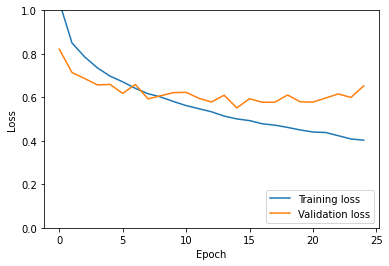

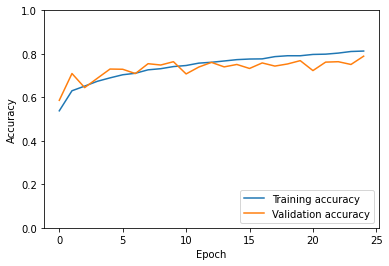

prediction =>  [8040 4996 3219 2338 1907]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,3906,2353,1523,1086,882
1,1397,928,578,462,335
2,1042,639,392,277,250
3,1014,615,431,294,271
4,681,461,295,219,169


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,330,51,7,1,1
1,117,27,4,0,0
2,91,12,1,0,0
3,86,12,4,1,2
4,57,11,5,0,0


filenames: 820
labels: 820
predictions: 820
prediction =>  [1914 1298  860  576  477]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,933,583,409,276,249
1,341,256,151,97,80
2,250,168,119,59,54
3,229,171,112,81,57
4,161,120,69,63,37


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,82,11,1,3,1
1,25,11,1,0,0
2,18,6,2,0,0
3,18,6,2,0,0
4,11,6,1,0,0


filenames: 205
labels: 205
predictions: 205
prediction =>  [1845 1189  398  431 1137]
predictions file: output_tf/LBQXbQW3YhLbLTPEQSYrKr/LBQXbQW3YhLbLTPEQSYrKr_predict_c2_h1_test.csv
Distribution
--------
0: 76
1: 59
2: 7
3: 8
4: 50
Finished generating predictions to output_tf/LBQXbQW3YhLbLTPEQSYrKr/LBQXbQW3YhLbLTPEQSYrKr_predict_c2_h1_test.csv


<tf.Tensor: shape=(5000,), dtype=int64, numpy=array([0, 2, 2, ..., 0, 0, 0])>

In [90]:
model = get_model(1024, 128, 0.5)
run_trial("h1", model)

#### H2: 2048-256-5

* DNN Structure: 2048-256-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Output generated to: output_tf/6DQMaQM8W7z4WpYYsUu9pM
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5000 images belonging to 1 classes.
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_34  (None, 512)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 2048)              1050624   
____________________________________________________________

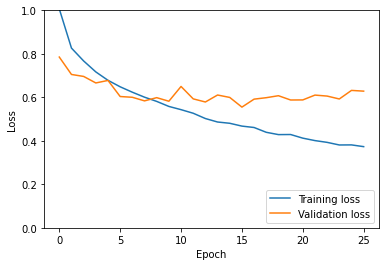

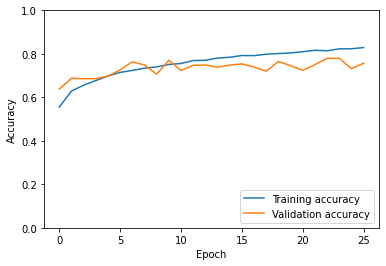

prediction =>  [8384 4332 3447 2451 1886]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,4022,2018,1641,1182,887
1,1490,775,641,440,354
2,1084,536,446,314,220
3,1046,596,420,302,261
4,742,407,299,213,164


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,356,21,12,1,0
1,138,3,6,1,0
2,94,7,3,0,0
3,93,10,2,0,0
4,65,7,1,0,0


filenames: 820
labels: 820
predictions: 820
prediction =>  [1966 1116  910  677  456]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,956,526,420,318,230
1,346,209,161,128,81
2,257,141,121,81,50
3,237,144,116,95,58
4,170,96,92,55,37


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,84,9,4,1,0
1,31,3,3,0,0
2,23,2,1,0,0
3,18,7,1,0,0
4,16,1,1,0,0


filenames: 205
labels: 205
predictions: 205
prediction =>  [1898  891  626  459 1126]
predictions file: output_tf/6DQMaQM8W7z4WpYYsUu9pM/6DQMaQM8W7z4WpYYsUu9pM_predict_c2_h2_test.csv
Distribution
--------
0: 83
1: 37
2: 20
3: 11
4: 49
Finished generating predictions to output_tf/6DQMaQM8W7z4WpYYsUu9pM/6DQMaQM8W7z4WpYYsUu9pM_predict_c2_h2_test.csv


<tf.Tensor: shape=(5000,), dtype=int64, numpy=array([0, 2, 2, ..., 0, 0, 0])>

In [91]:
model = get_model(2048, 256, 0.5)
run_trial("h2", model)

#### H3: 512-64-5

* DNN Structure: 512-64-5
* Dropout: 0.5
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Output generated to: output_tf/XDMVcNv6jRjaPzoE4TdwwL
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5000 images belonging to 1 classes.
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_35  (None, 512)               0         
_________________________________________________________________
dense_105 (Dense)            (None, 512)               262656    
____________________________________________________________

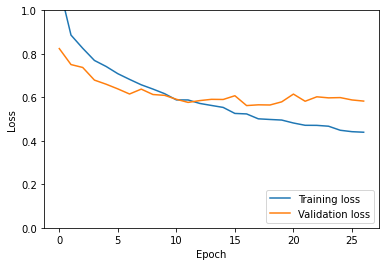

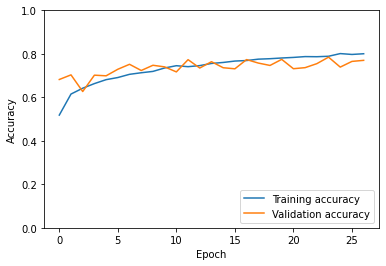

prediction =>  [9049 4147 2907 2583 1814]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,4325,1982,1385,1193,865
1,1587,703,555,514,341
2,1150,544,353,343,210
3,1164,543,345,334,239
4,823,375,269,199,159


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,371,17,0,2,0
1,138,9,0,1,0
2,97,6,1,0,0
3,101,3,0,1,0
4,66,6,0,1,0


filenames: 820
labels: 820
predictions: 820
prediction =>  [2156 1079  782  669  439]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1054,499,368,330,199
1,381,212,145,108,79
2,262,145,94,80,69
3,265,123,109,93,60
4,194,100,66,58,32


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,93,3,2,0,0
1,33,4,0,0,0
2,24,2,0,0,0
3,24,2,0,0,0
4,18,0,0,0,0


filenames: 205
labels: 205
predictions: 205
prediction =>  [1941 1060  383  607 1009]
predictions file: output_tf/XDMVcNv6jRjaPzoE4TdwwL/XDMVcNv6jRjaPzoE4TdwwL_predict_c2_h3_test.csv
Distribution
--------
0: 83
1: 45
2: 9
3: 17
4: 46
Finished generating predictions to output_tf/XDMVcNv6jRjaPzoE4TdwwL/XDMVcNv6jRjaPzoE4TdwwL_predict_c2_h3_test.csv


<tf.Tensor: shape=(5000,), dtype=int64, numpy=array([0, 2, 0, ..., 0, 0, 0])>

In [92]:
model = get_model(512, 64, 0.5)
run_trial("h3", model)

#### H4: Best from above, dropout 0.25

* DNN Structure: 
* Dropout: 0.25
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Output generated to: output_tf/NxGTtPkz6wwUGgtdWpFjwi
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5000 images belonging to 1 classes.
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_36  (None, 512)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 2048)              1050624   
____________________________________________________________

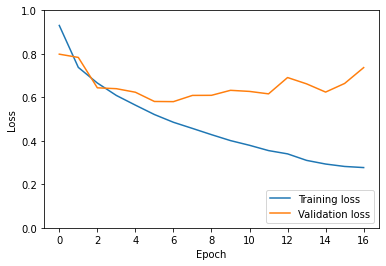

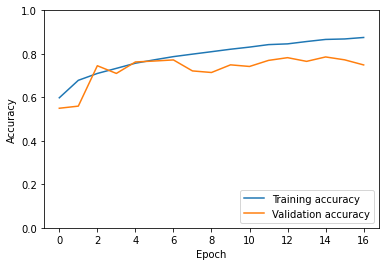

prediction =>  [9251 3973 3069 2331 1876]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,4450,1860,1412,1123,905
1,1646,744,548,419,343
2,1180,494,387,305,234
3,1187,515,412,282,229
4,788,360,310,202,165


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,374,9,5,1,1
1,133,12,1,1,1
2,102,1,1,0,0
3,104,1,0,0,0
4,67,4,2,0,0


filenames: 820
labels: 820
predictions: 820
prediction =>  [2228 1069  790  554  484]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1075,510,388,257,220
1,399,190,139,91,106
2,284,144,95,77,50
3,280,133,102,78,57
4,190,92,66,51,51


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,91,5,2,0,0
1,33,2,1,0,1
2,23,1,2,0,0
3,22,2,2,0,0
4,16,2,0,0,0


filenames: 205
labels: 205
predictions: 205
prediction =>  [2053  869  505  543 1030]
predictions file: output_tf/NxGTtPkz6wwUGgtdWpFjwi/NxGTtPkz6wwUGgtdWpFjwi_predict_c2_h4_test.csv
Distribution
--------
0: 89
1: 33
2: 17
3: 14
4: 47
Finished generating predictions to output_tf/NxGTtPkz6wwUGgtdWpFjwi/NxGTtPkz6wwUGgtdWpFjwi_predict_c2_h4_test.csv


<tf.Tensor: shape=(5000,), dtype=int64, numpy=array([0, 2, 0, ..., 0, 0, 0])>

In [93]:
model = get_model(2048, 256, 0.25)
run_trial("h4", model)

#### H5: Best from above, dropout 0.1

* DNN Structure: 
* Dropout: 0.1
* Class weights: [1,1,1,1,1]
* Batch normalization: no


Output generated to: output_tf/PK2xnvgursBEiJHEX3BBnB
Reading annotations...
Computing class weights...
{0: 0.4205128205128205, 1: 1.1081081081081081, 2: 1.5769230769230769, 3: 1.561904761904762, 4: 2.2465753424657535}
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5000 images belonging to 1 classes.
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_37  (None, 512)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 2048)              1050624   
____________________________________________________________

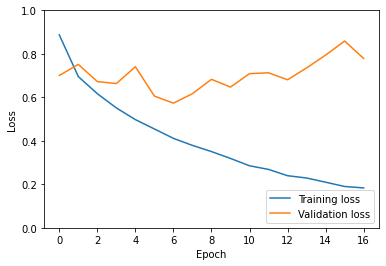

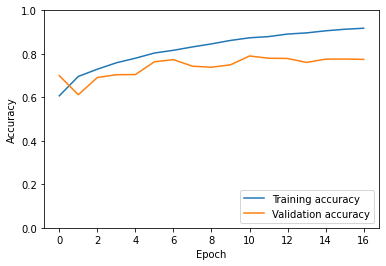

prediction =>  [8863 4118 3239 2442 1838]
Training Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,4170,1980,1531,1199,870
1,1627,757,529,450,337
2,1157,520,412,288,223
3,1090,536,463,293,243
4,819,325,304,212,165


Training Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,366,17,4,2,1
1,141,6,0,1,0
2,101,3,0,0,0
3,95,6,4,0,0
4,72,1,0,0,0


filenames: 820
labels: 820
predictions: 820
prediction =>  [2123 1077  806  667  452]
Validation Confusion Matrix of Patches
------------------------------


,0,1,2,3,4
0,1021,527,383,313,206
1,378,179,146,130,92
2,260,141,106,81,62
3,275,137,96,83,59
4,189,93,75,60,33


Validation Confusion Matrix of Whole Images
------------------------------


,0,1,2,3,4
0,87,8,2,1,0
1,34,2,1,0,0
2,24,2,0,0,0
3,24,1,1,0,0
4,18,0,0,0,0


filenames: 205
labels: 205
predictions: 205
prediction =>  [1724 1095  581  603  997]
predictions file: output_tf/PK2xnvgursBEiJHEX3BBnB/PK2xnvgursBEiJHEX3BBnB_predict_c2_h5_test.csv
Distribution
--------
0: 78
1: 41
2: 15
3: 22
4: 44
Finished generating predictions to output_tf/PK2xnvgursBEiJHEX3BBnB/PK2xnvgursBEiJHEX3BBnB_predict_c2_h5_test.csv


<tf.Tensor: shape=(5000,), dtype=int64, numpy=array([2, 2, 2, ..., 0, 0, 0])>

In [94]:
model = get_model(2048, 256, 0.1)
run_trial("h5", model)

#### H6: Best from above, skewed class weights

* DNN Structure: 
* Dropout: 0.5
* Class weights: [1,1,5,5,1]
* Batch normalization: no


In [ ]:
model = get_model(2048, 256, 0.5)
run_trial("h6", model, class_weights=[1., 1., 2., 2., 1.])

Output generated to: output_tf/TDWQvEA4xRKXbjSmNF2sb2
Reading annotations...
Using class weights: [1.0, 1.0, 2.0, 2.0, 1.0]
Defining train data generator...
Found 20500 validated image filenames belonging to 5 classes.
Defining validation data generator...
Found 5125 validated image filenames belonging to 5 classes.
Found 5000 images belonging to 1 classes.
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_38  (None, 512)               0         
_________________________________________________________________
dense_114 (Dense)            (None, 2048)              1050624   
_________________________________________________________________
dropout_76 (Dropout)         (None, 2048)              0         
_______________________

#### H7: Best from above, batch normalization

* DNN Structure: 
* Dropout: 0.5
* Class weights: 
* Batch normalization: yes


In [ ]:
# Not currently available in Keras

#model = get_model(n1, n2, 0.5)
#run_trial("h7", model)

#### Summary: Best hyperparameters

In [ ]:
optimal_n1 = 1024
optimal_n2 = 128
optimal_d = 0.1


## Train with all C2 data and optimal hyperparameters

In [ ]:
model = get_model(optimal_n1, optimal_n2, optimal_d)
# model.load_state_dict(torch.load('cnn_pytorch_c2.pt'))
y_hat_test = train_and_test(model, group_3(), num_epochs=40)
predictions_file = "predict_c2_{}.csv".format(shortuuid.uuid())
print('predictions file:', predictions_file)
predict_whole_images(y_hat_test, PATCH_ROWS, PATCH_COLUMNS, predictions_file)